### Start

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import pandas as pd
import seaborn as sns

In [3]:
# check pytorch version
print(torch.__version__)

# check cuda availability
print(torch.cuda.is_available())

# check cuda version
print(torch.version.cuda)

1.11.0+cu113
True
11.3


### Representing an image

* Converting images into strutured arrays and scalars

In [4]:
# import wget
# url = 'https://www.dropbox.com/s/l98leemr7r5stnm/Hemanvi.jpeg'
# filename = wget.download(url)
# filename

In [5]:
import cv2
import matplotlib.pyplot as plt

In [6]:
# filename = 'Hemanvi.jpeg'
# img = cv2.imread(filename)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# plt.imshow(img, cmap='gray')
# plt.show()

In [7]:
# img_gray_small = cv2.resize(img,(25,25))
# plt.imshow(img_gray_small, cmap='gray')

### Preparing our data for image classification

In [8]:
folder_name = 'data_folder'
# check folder_name exists or not
# if not, create it
import os
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

In [9]:
# 1. Download the MNIST dataset
from torchvision import datasets
mnist_folder = "./" + folder_name + "/MNIST"
fmnist = datasets.FashionMNIST(folder_name, train=True, download=True)
# Store images and targets
tr_images = fmnist.data
tr_targets = fmnist.targets

In [10]:
# 2. Inspect the tensors that we are dealing with:
unique_values = tr_targets.unique()
print(f'tr_images & tr_targets:\n\tX -{tr_images.shape}\n\tY \
-{tr_targets.shape}\n\tY-Unique Values : {unique_values}')
print(f'TASK:\n\t{len(unique_values)} class Classification')
print(f'UNIQUE CLASSES:\n\t{fmnist.classes}')

tr_images & tr_targets:
	X -torch.Size([60000, 28, 28])
	Y -torch.Size([60000])
	Y-Unique Values : tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
TASK:
	10 class Classification
UNIQUE CLASSES:
	['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


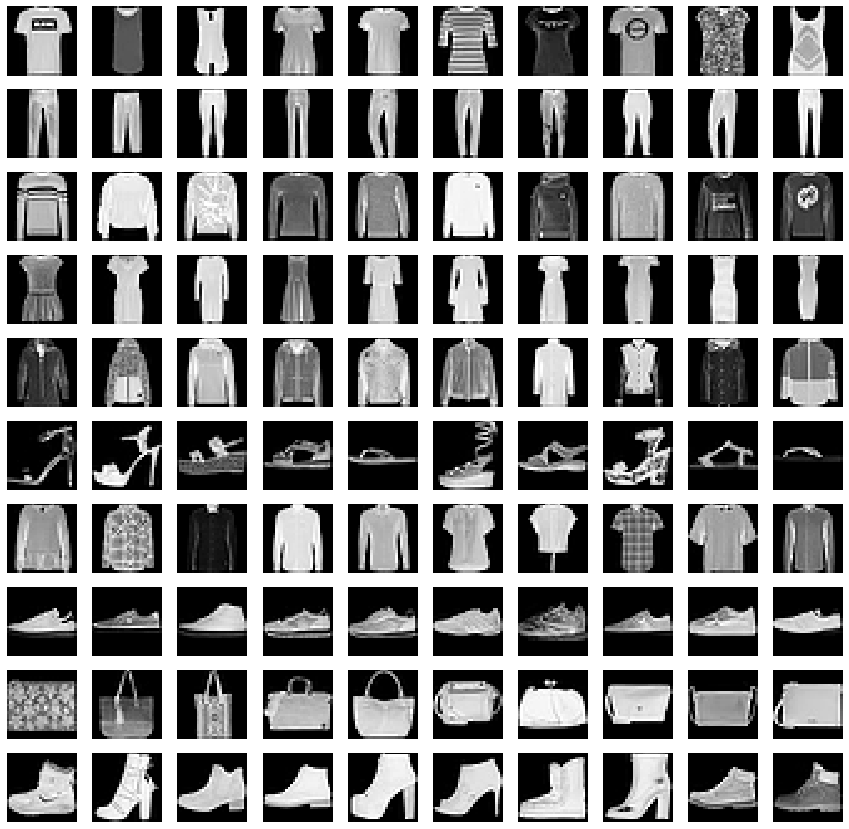

In [11]:
# 3. Plot a random sample of 10 images for all the 10 possible classes:
fig, ax = plt.subplots(10, 10, figsize=(15, 15))
for i in range(10):
    for j in range(10):
        ax[i, j].imshow(tr_images[tr_targets == i][j], cmap='gray')
        ax[i, j].axis('off')
plt.show()


### Traning a neural network

To train a neural network, we must perform the following steps:
1. Import the relevant packages.
2. Build a dataset that can fetch data one data point at a time.
3. Wrap the DataLoader from the dataset.
4. Build a model and then define the loss function and the optimizer.
5. Define two functions to train and validate a batch of data, respectively.
6. Define a function that will calculate the accuracy of the data.
7. Perform weight updates based on each batch of data over increasing
epochs.

In [12]:
# 1. Import the relevant packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms

mnist_folder = "./" + folder_name + "/MNIST"
device = "cuda" if torch.cuda.is_available() else "cpu"
fminst = datasets.FashionMNIST(mnist_folder, train=True, download=True)
train_images = fminst.data
train_targets = fminst.targets

In [13]:
# 2. Build a dataset that can fetch data one data point at a time
class FMNISTDataset(Dataset):
    def __init__(self, data, targets):
        data = data.float().view(-1, 28*28)
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        return x.to(device), y.to(device)

In [14]:
# 3. Create a function that generates a training DataLoader
# This will sample 32 data points at random for the batch size:
def get_data():
    train = FMNISTDataset(train_images, train_targets)
    train_loader = DataLoader(train, batch_size=32, shuffle=True)
    return train_loader

In [15]:
# 4. Define a model, as well as the loss function
# and the optimizer that we will use to train the model:
from torch.optim import SGD
def get_model():
    model = nn.Sequential(
        nn.Linear(28*28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=1e-2)
    return model, loss_fn, optimizer

In [16]:
# 5. Define a function that will train the dataset on a batch of images:
def train_batch(x, y, model, opt, loss_fn):
    model.train()

    prediction = model(x)

    # Compute loss
    batch_loss = loss_fn(prediction, y)

    # Based on the forward pass in 'model(x)', compute 
    # all the gradients of 'model.parameters()'
    batch_loss.backward()

    # Apply new-weights = f(old-weights, old-weight-gradients)
    # where 'f' is the optimizer
    opt.step()

    # Flush gradients memory for next batch of calculations
    opt.zero_grad()
    
    return batch_loss.item()

In [17]:
# 6. Build a function that calculates the accuracy of a given dataset:

# since there's no need for updating weights,
# we might as well not compute the gradients.
# Using this '@' decorator on top of functions
# will disable gradient computation in the entire function
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()

    prediction = model(x)

    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y

    return is_correct.cpu().numpy().tolist()

In [18]:
# 7. Traning the neural network:

# * Initialize the model, loss function, and optimizer
model, loss_fn, optimizer = get_model()
train_dl = get_data()

# * Invoke the lists that contain the accuracy and loss values at the end of each epoch:
train_losses = []
train_accuracies = []

# * Define the number of epochs:
epochs = 5
for epoch in range(epochs):
    print(epoch)
# * Invoke the list that will contain the accuracy
# and loss values corresponding to each batch within an epoch:
    epoch_losses = []
    epoch_accuracies = []

# * Create batches of training data by iterating through the DataLoader:
    for ix, batch in enumerate(iter(train_dl)):
        x, y = batch

# * Train the batch using train_batch function and store the loss
# value at the end of training on top of the batch as batch_loss. 
# Also, store the loss value across batches in the epoch_losses list:
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        epoch_losses.append(batch_loss)

# * Store the mean loss value across all batches with an epoch:
    epoch_losses = np.array(epoch_losses).mean()

#  * Calculate the accuracy of the prediction at the 
# end of training on all batches:
    for ix, batch in enumerate(iter(train_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        epoch_accuracies.append(accuracy(x, y, model))
    epoch_accuracies = np.mean(epoch_accuracies)

# * Store the loss and accuracy values at the end of each epoch in a list:
    train_losses.append(epoch_losses)
    train_accuracies.append(epoch_accuracies)

0
1
2
3
4


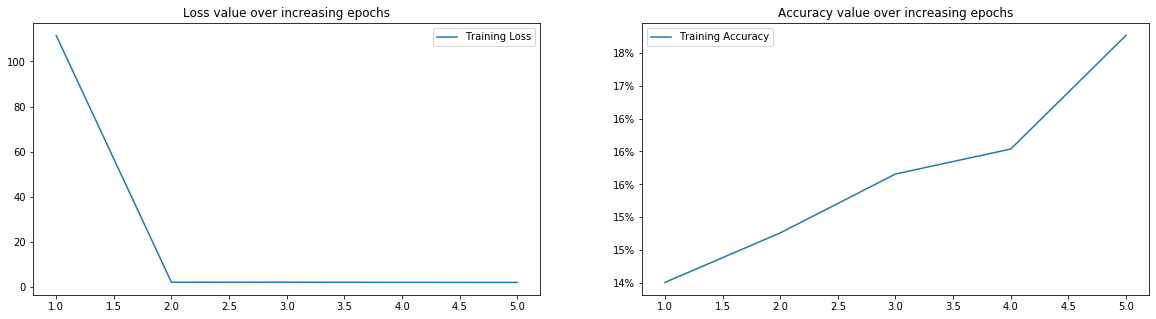

In [19]:
epochs = np.arange(epochs)+1
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs, train_losses, label='Training Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \
for x in plt.gca().get_yticks()])
plt.legend()
plt.show()

### Scaling a dataset to improve model accuracy

In [20]:
# Scaling a dataset is the process of ensuring that the variables are confined to a finite
# range. In this section, we will confine the independent variables' values to values
# between 0 and 1 by dividing each input value by the maximum possible value in the
# dataset. This is a value of 255, which corresponds to white pixels:

In [21]:
# 1.Fetch the training data:
fmnist = datasets.FashionMNIST(mnist_folder, train=True, download=True)
train_images = fmnist.data
train_targets = fmnist.targets

In [22]:
# 2. Modify FMNISTDataset, which fetches data, so that the input
# image is divided by 255 (the maximum possible value):
class FMNISTDataset(Dataset):
    def __init__(self, data, targets):
        data = data.float().view(-1, 28*28)
        self.data = data/255
        self.targets = targets

    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        return x.to(device), y.to(device)

In [23]:
# 3. Train a model on the scaled dataset:

# Create a function that generates a training DataLoader
# This will sample 32 data points at random for the batch size:
def get_data():
    train = FMNISTDataset(train_images, train_targets)
    train_loader = DataLoader(train, batch_size=32, shuffle=True)
    return train_loader

# Create a function that generates a model, loss function, and optimizer:
def get_model():
    model = nn.Sequential(
        nn.Linear(28*28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=1e-2)
    return model, loss_fn, optimizer

# Create a function that trains the dataset on a batch of images:
def train_batch(x, y, model, opt, loss_fn):
    model.train()

    prediction = model(x)

    # Compute loss
    batch_loss = loss_fn(prediction, y)

    # Based on the forward pass in 'model(x)', compute 
    # all the gradients of 'model.parameters()'
    batch_loss.backward()

    # Apply new-weights = f(old-weights, old-weight-gradients)
    # where 'f' is the optimizer
    opt.step()

    # Flush gradients memory for next batch of calculations
    opt.zero_grad()
    
    return batch_loss.item()

# Create a function that calculates the accuracy of a given dataset:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()

    prediction = model(x)

    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y

    return is_correct.cpu().numpy().tolist()

# Initialize the model, loss function, and optimizer
model, loss_fn, optimizer = get_model()
train_dl = get_data()
losses, accuracies = [], []
epochs_train = 5
for epoch in range(epochs_train):
    print(epoch)
    epoch_losses = []
    epoch_accuracies = []
    for ix, batch in enumerate(iter(train_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        epoch_losses.append(batch_loss)

    epoch_loss = np.array(epoch_losses).mean()

    for ix, batch in enumerate(iter(train_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        epoch_accuracies.extend(is_correct)
    epoch_accuracies = np.mean(epoch_accuracies)
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracies)

0
1
2
3
4


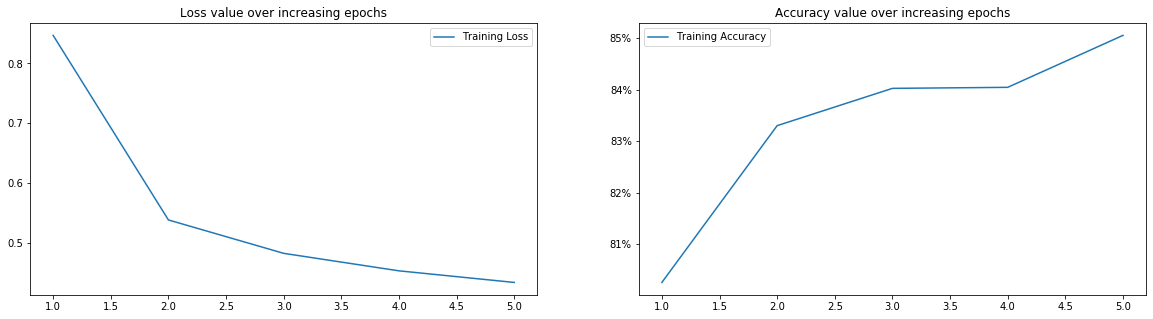

In [24]:
epochs = np.arange(epochs_train)+1
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs, losses, label='Training Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \
for x in plt.gca().get_yticks()])
plt.legend()
plt.show()

* Scaling the input dataset so that it contains a much smaller range of values generally helps in achieving better model accuracy.

### Understanding the impact of varying the batch size

* Batchsize = 32

In [25]:
# 3. Train a model on the scaled dataset:

batchsize = 32
# Create a function that generates a training DataLoader
# This will sample 32 data points at random for the batch size:
def get_data():
    train = FMNISTDataset(train_images, train_targets)
    train_loader = DataLoader(train, batch_size=batchsize, shuffle=True)
    return train_loader

# Create a function that generates a model, loss function, and optimizer:
def get_model():
    model = nn.Sequential(
        nn.Linear(28*28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=1e-2)
    return model, loss_fn, optimizer

# Create a function that trains the dataset on a batch of images:
def train_batch(x, y, model, opt, loss_fn):
    model.train()

    prediction = model(x)

    # Compute loss
    batch_loss = loss_fn(prediction, y)

    # Based on the forward pass in 'model(x)', compute 
    # all the gradients of 'model.parameters()'
    batch_loss.backward()

    # Apply new-weights = f(old-weights, old-weight-gradients)
    # where 'f' is the optimizer
    opt.step()

    # Flush gradients memory for next batch of calculations
    opt.zero_grad()
    
    return batch_loss.item()

# Create a function that calculates the accuracy of a given dataset:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()

    prediction = model(x)

    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y

    return is_correct.cpu().numpy().tolist()

# Initialize the model, loss function, and optimizer
model, loss_fn, optimizer = get_model()
train_dl = get_data()
losses, accuracies = [], []
epochs_train = 5
for epoch in range(epochs_train):
    print(epoch)
    epoch_losses = []
    epoch_accuracies = []
    for ix, batch in enumerate(iter(train_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        epoch_losses.append(batch_loss)

    epoch_loss = np.array(epoch_losses).mean()

    for ix, batch in enumerate(iter(train_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        epoch_accuracies.extend(is_correct)
    epoch_accuracies = np.mean(epoch_accuracies)
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracies)

0
1
2
3
4


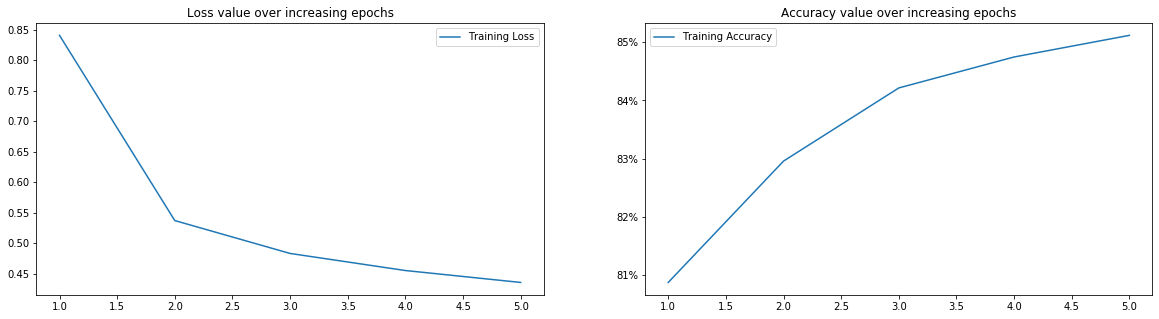

In [26]:
epochs = np.arange(epochs_train)+1
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs, losses, label='Training Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \
for x in plt.gca().get_yticks()])
plt.legend()
plt.show()

* Batchsize = 10000

In [27]:
# 3. Train a model on the scaled dataset:

batchsize = 10000
# Create a function that generates a training DataLoader
# This will sample 32 data points at random for the batch size:
def get_data():
    train = FMNISTDataset(train_images, train_targets)
    train_loader = DataLoader(train, batch_size=batchsize, shuffle=True)
    return train_loader

# Create a function that generates a model, loss function, and optimizer:
def get_model():
    model = nn.Sequential(
        nn.Linear(28*28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=1e-2)
    return model, loss_fn, optimizer

# Create a function that trains the dataset on a batch of images:
def train_batch(x, y, model, opt, loss_fn):
    model.train()

    prediction = model(x)

    # Compute loss
    batch_loss = loss_fn(prediction, y)

    # Based on the forward pass in 'model(x)', compute 
    # all the gradients of 'model.parameters()'
    batch_loss.backward()

    # Apply new-weights = f(old-weights, old-weight-gradients)
    # where 'f' is the optimizer
    opt.step()

    # Flush gradients memory for next batch of calculations
    opt.zero_grad()
    
    return batch_loss.item()

# Create a function that calculates the accuracy of a given dataset:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()

    prediction = model(x)

    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y

    return is_correct.cpu().numpy().tolist()

# Initialize the model, loss function, and optimizer
model, loss_fn, optimizer = get_model()
train_dl = get_data()
losses, accuracies = [], []
epochs_train = 5
for epoch in range(epochs_train):
    print(epoch)
    epoch_losses = []
    epoch_accuracies = []
    for ix, batch in enumerate(iter(train_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        epoch_losses.append(batch_loss)

    epoch_loss = np.array(epoch_losses).mean()

    for ix, batch in enumerate(iter(train_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        epoch_accuracies.extend(is_correct)
    epoch_accuracies = np.mean(epoch_accuracies)
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracies)

0
1
2
3
4


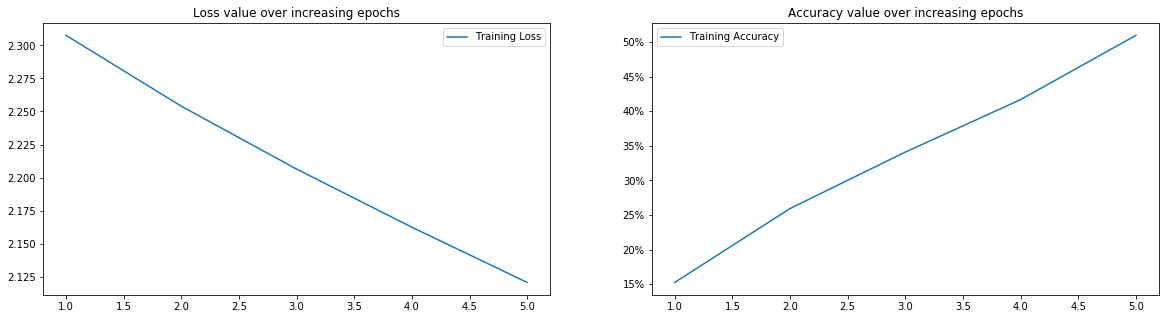

In [28]:
epochs = np.arange(epochs_train)+1
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs, losses, label='Training Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \
for x in plt.gca().get_yticks()])
plt.legend()
plt.show()

* Having a lower batch size generally helps in achieving optimal accuracy when you have a small number of epochs, but it should not be so low that training time is impacted.

### Understanding the impact of varying the loss optimizer

* SGD

In [29]:
# 3. Train a model on the scaled dataset:

batchsize = 32
# Create a function that generates a training DataLoader
# This will sample 32 data points at random for the batch size:
def get_data():
    train = FMNISTDataset(train_images, train_targets)
    train_loader = DataLoader(train, batch_size=batchsize, shuffle=True)
    return train_loader

# Create a function that generates a model, loss function, and optimizer:
def get_model():
    model = nn.Sequential(
        nn.Linear(28*28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=1e-2)
    return model, loss_fn, optimizer

# Create a function that trains the dataset on a batch of images:
def train_batch(x, y, model, opt, loss_fn):
    model.train()

    prediction = model(x)

    # Compute loss
    batch_loss = loss_fn(prediction, y)

    # Based on the forward pass in 'model(x)', compute 
    # all the gradients of 'model.parameters()'
    batch_loss.backward()

    # Apply new-weights = f(old-weights, old-weight-gradients)
    # where 'f' is the optimizer
    opt.step()

    # Flush gradients memory for next batch of calculations
    opt.zero_grad()
    
    return batch_loss.item()

# Create a function that calculates the accuracy of a given dataset:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()

    prediction = model(x)

    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y

    return is_correct.cpu().numpy().tolist()

# Initialize the model, loss function, and optimizer
model, loss_fn, optimizer = get_model()
train_dl = get_data()
losses, accuracies = [], []
epochs_train = 13
for epoch in range(epochs_train):
    print(epoch)
    epoch_losses = []
    epoch_accuracies = []
    for ix, batch in enumerate(iter(train_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        epoch_losses.append(batch_loss)

    epoch_loss = np.array(epoch_losses).mean()

    for ix, batch in enumerate(iter(train_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        epoch_accuracies.extend(is_correct)
    epoch_accuracies = np.mean(epoch_accuracies)
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracies)

0
1
2
3
4
5
6
7
8
9
10
11
12


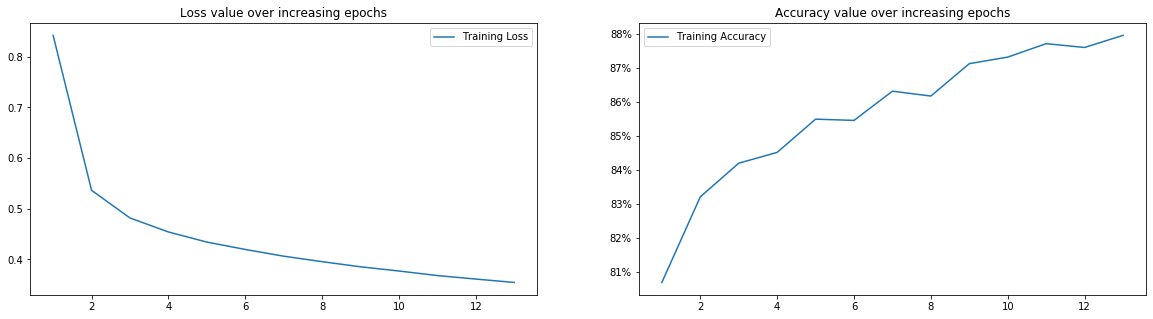

In [30]:
epochs = np.arange(epochs_train)+1
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs, losses, label='Training Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \
for x in plt.gca().get_yticks()])
plt.legend()
plt.show()

* Adam

In [31]:
# 3. Train a model on the scaled dataset:
from torch.optim import Adam
batchsize = 32
# Create a function that generates a training DataLoader
# This will sample 32 data points at random for the batch size:
def get_data():
    train = FMNISTDataset(train_images, train_targets)
    train_loader = DataLoader(train, batch_size=batchsize, shuffle=True)
    return train_loader

# Create a function that generates a model, loss function, and optimizer:
def get_model():
    model = nn.Sequential(
        nn.Linear(28*28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-2)
    return model, loss_fn, optimizer

# Create a function that trains the dataset on a batch of images:
def train_batch(x, y, model, opt, loss_fn):
    model.train()

    prediction = model(x)

    # Compute loss
    batch_loss = loss_fn(prediction, y)

    # Based on the forward pass in 'model(x)', compute 
    # all the gradients of 'model.parameters()'
    batch_loss.backward()

    # Apply new-weights = f(old-weights, old-weight-gradients)
    # where 'f' is the optimizer
    opt.step()

    # Flush gradients memory for next batch of calculations
    opt.zero_grad()
    
    return batch_loss.item()

# Create a function that calculates the accuracy of a given dataset:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()

    prediction = model(x)

    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y

    return is_correct.cpu().numpy().tolist()

# Initialize the model, loss function, and optimizer
model, loss_fn, optimizer = get_model()
train_dl = get_data()
losses, accuracies = [], []
epochs_train = 13
for epoch in range(epochs_train):
    print(epoch)
    epoch_losses = []
    epoch_accuracies = []
    for ix, batch in enumerate(iter(train_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        epoch_losses.append(batch_loss)

    epoch_loss = np.array(epoch_losses).mean()

    for ix, batch in enumerate(iter(train_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        epoch_accuracies.extend(is_correct)
    epoch_accuracies = np.mean(epoch_accuracies)
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracies)

0
1
2
3
4
5
6
7
8
9
10
11
12


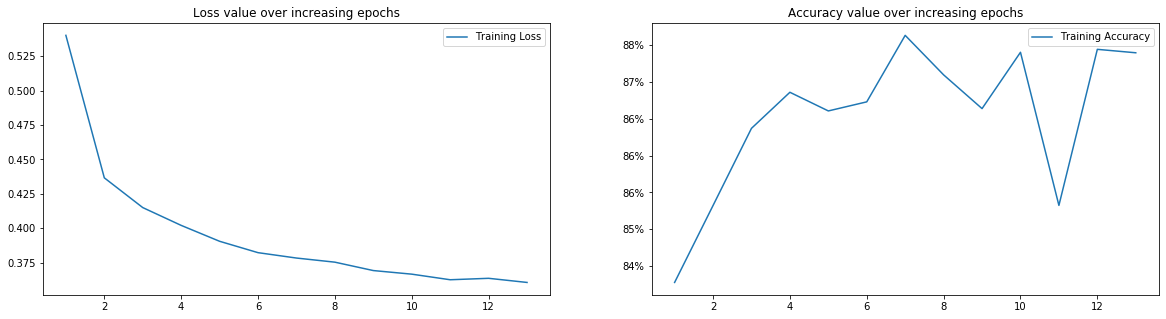

In [32]:
epochs = np.arange(epochs_train)+1
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs, losses, label='Training Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \
for x in plt.gca().get_yticks()])
plt.legend()
plt.show()

* Certain optimizers achieve optimal accuracy faster compared to others. Adam generally achieves optimal accuracy faster. Some of the other prominent optimizers that are available include Adagrad, Adadelta, AdamW, LBFGS, and RMSprop.

### Understanding the impact of varying the learning rate

* Higher LR = 0.1 on scaled dataset

In [33]:
# 2. Modify FMNISTDataset, which fetches data, so that the input
# image is divided by 255 (the maximum possible value):
class FMNISTDataset(Dataset):
    def __init__(self, data, targets):
        data = data.float().view(-1, 28*28)
        self.data = data/255
        self.targets = targets

    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        return x.to(device), y.to(device)

In [34]:
# 3. Train a model on the scaled dataset:
from torch.optim import Adam
batchsize = 32
# Create a function that generates a training DataLoader
# This will sample 32 data points at random for the batch size:
def get_data():
    train = FMNISTDataset(train_images, train_targets)
    train_loader = DataLoader(train, batch_size=batchsize, shuffle=True)
    return train_loader

# Create a function that generates a model, loss function, and optimizer:
def get_model():
    model = nn.Sequential(
        nn.Linear(28*28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=1e-1)
    return model, loss_fn, optimizer

# Create a function that trains the dataset on a batch of images:
def train_batch(x, y, model, opt, loss_fn):
    model.train()

    prediction = model(x)

    # Compute loss
    batch_loss = loss_fn(prediction, y)

    # Based on the forward pass in 'model(x)', compute 
    # all the gradients of 'model.parameters()'
    batch_loss.backward()

    # Apply new-weights = f(old-weights, old-weight-gradients)
    # where 'f' is the optimizer
    opt.step()

    # Flush gradients memory for next batch of calculations
    opt.zero_grad()
    
    return batch_loss.item()

# Create a function that calculates the accuracy of a given dataset:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()

    prediction = model(x)

    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y

    return is_correct.cpu().numpy().tolist()

# Initialize the model, loss function, and optimizer
model, loss_fn, optimizer = get_model()
train_dl = get_data()
losses, accuracies = [], []
epochs_train = 5
for epoch in range(epochs_train):
    print(epoch)
    epoch_losses = []
    epoch_accuracies = []
    for ix, batch in enumerate(iter(train_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        epoch_losses.append(batch_loss)

    epoch_loss = np.array(epoch_losses).mean()

    for ix, batch in enumerate(iter(train_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        epoch_accuracies.extend(is_correct)
    epoch_accuracies = np.mean(epoch_accuracies)
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracies)

0
1
2
3
4


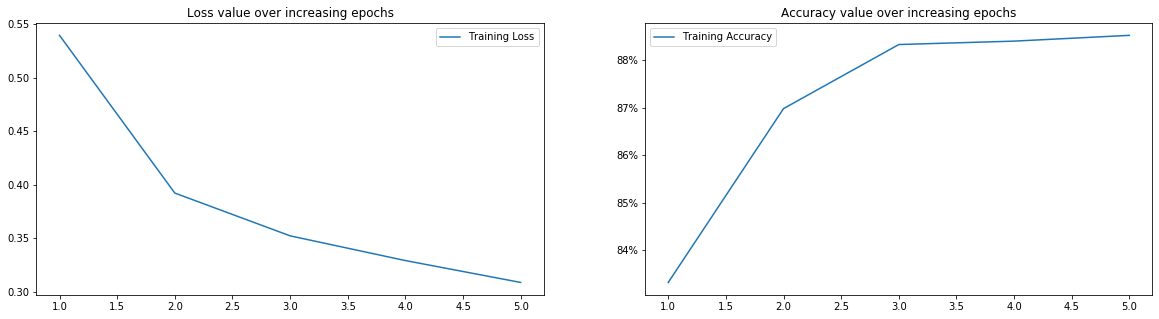

In [35]:
epochs = np.arange(epochs_train)+1
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs, losses, label='Training Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \
for x in plt.gca().get_yticks()])
plt.legend()
plt.show()

* Lower LR = 0.00001 on scaled dataset

In [36]:
# 3. Train a model on the scaled dataset:
from torch.optim import Adam
batchsize = 32
# Create a function that generates a training DataLoader
# This will sample 32 data points at random for the batch size:
def get_data():
    train = FMNISTDataset(train_images, train_targets)
    train_loader = DataLoader(train, batch_size=batchsize, shuffle=True)
    return train_loader

# Create a function that generates a model, loss function, and optimizer:
def get_model():
    model = nn.Sequential(
        nn.Linear(28*28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=1e-4)
    return model, loss_fn, optimizer

# Create a function that trains the dataset on a batch of images:
def train_batch(x, y, model, opt, loss_fn):
    model.train()

    prediction = model(x)

    # Compute loss
    batch_loss = loss_fn(prediction, y)

    # Based on the forward pass in 'model(x)', compute 
    # all the gradients of 'model.parameters()'
    batch_loss.backward()

    # Apply new-weights = f(old-weights, old-weight-gradients)
    # where 'f' is the optimizer
    opt.step()

    # Flush gradients memory for next batch of calculations
    opt.zero_grad()
    
    return batch_loss.item()

# Create a function that calculates the accuracy of a given dataset:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()

    prediction = model(x)

    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y

    return is_correct.cpu().numpy().tolist()

# Initialize the model, loss function, and optimizer
model, loss_fn, optimizer = get_model()
train_dl = get_data()
losses, accuracies = [], []
epochs_train = 5
for epoch in range(epochs_train):
    print(epoch)
    epoch_losses = []
    epoch_accuracies = []
    for ix, batch in enumerate(iter(train_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        epoch_losses.append(batch_loss)

    epoch_loss = np.array(epoch_losses).mean()

    for ix, batch in enumerate(iter(train_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        epoch_accuracies.extend(is_correct)
    epoch_accuracies = np.mean(epoch_accuracies)
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracies)

0
1
2
3
4


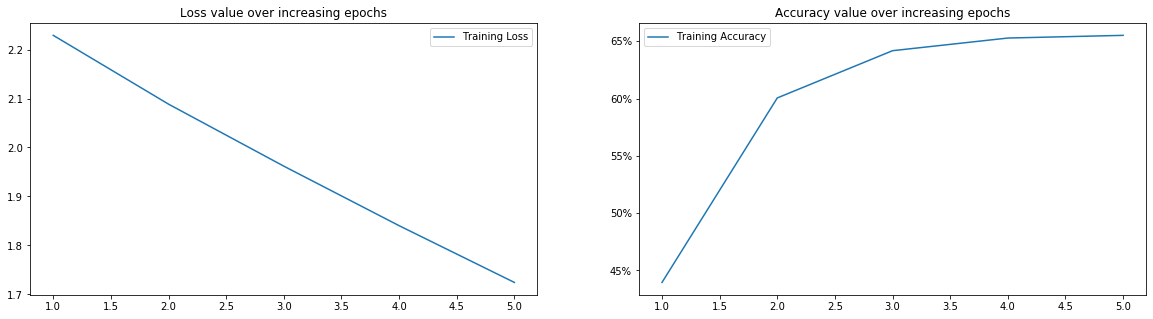

In [37]:
epochs = np.arange(epochs_train)+1
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs, losses, label='Training Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \
for x in plt.gca().get_yticks()])
plt.legend()
plt.show()

* Higher LR = 0.1 on non-scaled dataset

In [38]:
# 2. Modify FMNISTDataset, which fetches data, so that the input
# image is divided by 255 (the maximum possible value):
class FMNISTDataset(Dataset):
    def __init__(self, data, targets):
        data = data.float().view(-1, 28*28)
        self.data = data
        self.targets = targets

    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        return x.to(device), y.to(device)

In [39]:
# 3. Train a model on the scaled dataset:
from torch.optim import Adam
batchsize = 32
# Create a function that generates a training DataLoader
# This will sample 32 data points at random for the batch size:
def get_data():
    train = FMNISTDataset(train_images, train_targets)
    train_loader = DataLoader(train, batch_size=batchsize, shuffle=True)
    return train_loader

# Create a function that generates a model, loss function, and optimizer:
def get_model():
    model = nn.Sequential(
        nn.Linear(28*28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=1e-1)
    return model, loss_fn, optimizer

# Create a function that trains the dataset on a batch of images:
def train_batch(x, y, model, opt, loss_fn):
    model.train()

    prediction = model(x)

    # Compute loss
    batch_loss = loss_fn(prediction, y)

    # Based on the forward pass in 'model(x)', compute 
    # all the gradients of 'model.parameters()'
    batch_loss.backward()

    # Apply new-weights = f(old-weights, old-weight-gradients)
    # where 'f' is the optimizer
    opt.step()

    # Flush gradients memory for next batch of calculations
    opt.zero_grad()
    
    return batch_loss.item()

# Create a function that calculates the accuracy of a given dataset:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()

    prediction = model(x)

    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y

    return is_correct.cpu().numpy().tolist()

# Initialize the model, loss function, and optimizer
model, loss_fn, optimizer = get_model()
train_dl = get_data()
losses, accuracies = [], []
epochs_train = 13
for epoch in range(epochs_train):
    print(epoch)
    epoch_losses = []
    epoch_accuracies = []
    for ix, batch in enumerate(iter(train_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        epoch_losses.append(batch_loss)

    epoch_loss = np.array(epoch_losses).mean()

    for ix, batch in enumerate(iter(train_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        epoch_accuracies.extend(is_correct)
    epoch_accuracies = np.mean(epoch_accuracies)
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracies)

0
1
2
3
4
5
6
7
8
9
10
11
12


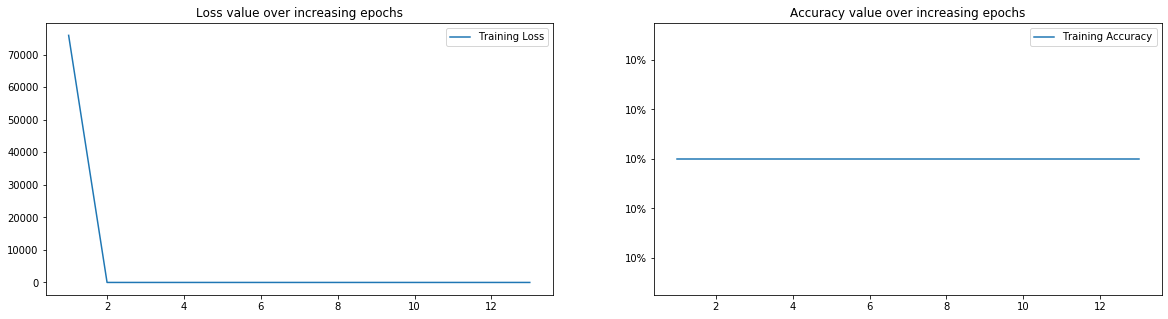

In [40]:
epochs = np.arange(epochs_train)+1
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs, losses, label='Training Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \
for x in plt.gca().get_yticks()])
plt.legend()
plt.show()

* Lower LR = 0.00001 on non-scaled dataset

In [41]:
# 3. Train a model on the scaled dataset:
from torch.optim import Adam
batchsize = 32
# Create a function that generates a training DataLoader
# This will sample 32 data points at random for the batch size:
def get_data():
    train = FMNISTDataset(train_images, train_targets)
    train_loader = DataLoader(train, batch_size=batchsize, shuffle=True)
    return train_loader

# Create a function that generates a model, loss function, and optimizer:
def get_model():
    model = nn.Sequential(
        nn.Linear(28*28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=1e-4)
    return model, loss_fn, optimizer

# Create a function that trains the dataset on a batch of images:
def train_batch(x, y, model, opt, loss_fn):
    model.train()

    prediction = model(x)

    # Compute loss
    batch_loss = loss_fn(prediction, y)

    # Based on the forward pass in 'model(x)', compute 
    # all the gradients of 'model.parameters()'
    batch_loss.backward()

    # Apply new-weights = f(old-weights, old-weight-gradients)
    # where 'f' is the optimizer
    opt.step()

    # Flush gradients memory for next batch of calculations
    opt.zero_grad()
    
    return batch_loss.item()

# Create a function that calculates the accuracy of a given dataset:
@torch.no_grad()
def accuracy(x, y, model):
    model.eval()

    prediction = model(x)

    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y

    return is_correct.cpu().numpy().tolist()

# Initialize the model, loss function, and optimizer
model, loss_fn, optimizer = get_model()
train_dl = get_data()
losses, accuracies = [], []
epochs_train = 13
for epoch in range(epochs_train):
    print(epoch)
    epoch_losses = []
    epoch_accuracies = []
    for ix, batch in enumerate(iter(train_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        epoch_losses.append(batch_loss)

    epoch_loss = np.array(epoch_losses).mean()

    for ix, batch in enumerate(iter(train_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        epoch_accuracies.extend(is_correct)
    epoch_accuracies = np.mean(epoch_accuracies)
    losses.append(epoch_loss)
    accuracies.append(epoch_accuracies)

0
1
2
3
4
5
6
7
8
9
10
11
12


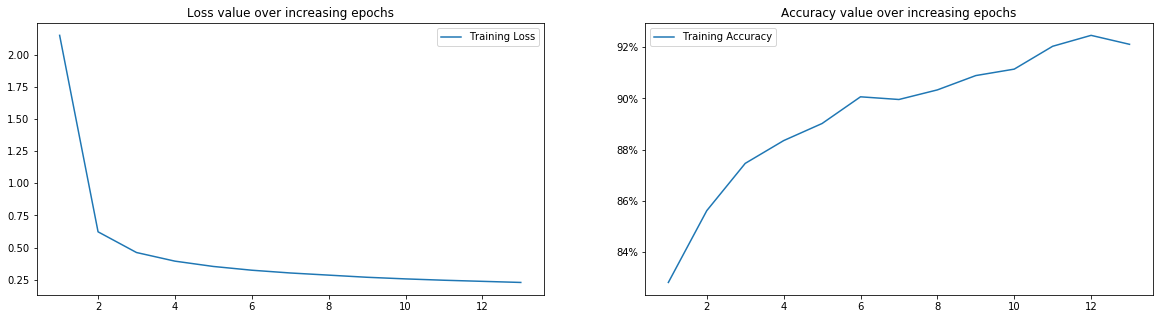

In [42]:
epochs = np.arange(epochs_train)+1
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs, losses, label='Training Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs, accuracies, label='Training Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \
for x in plt.gca().get_yticks()])
plt.legend()
plt.show()

In [43]:
val_fmnist =datasets.FashionMNIST(mnist_folder,download=True, \
train=False)
val_images = val_fmnist.data
val_targets = val_fmnist.targets

* When the learning rate is high, parameters have a much larger distribution compared to medium and low learning rates.
* When parameters have a bigger distribution, overfitting occurs.

* Generally, a learning rate of 0.001 works. Having a very low learning rate means it will take a long time to train the model, while having a high learning rate results in the model becoming unstable.

### Understanding the impact of learning rate annealing

In [44]:
# 2. Modify FMNISTDataset, which fetches data, so that the input
# image is divided by 255 (the maximum possible value):
class FMNISTDataset(Dataset):
    def __init__(self, data, targets):
        data = data.float().view(-1, 28*28)
        self.data = data / 255.
        self.targets = targets

    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        return x.to(device), y.to(device)

In [45]:
def get_data():
    train = FMNISTDataset(tr_images, tr_targets)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True)
    val = FMNISTDataset(val_images, val_targets)
    val_dl = DataLoader(val, batch_size=len(val_images),
    shuffle=False)
    return trn_dl, val_dl

In [46]:
from torch import optim
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    patience=1, 
    verbose=True,
    factor=0.5,
    min_lr=1e-6,
    threshold= 0.001,
    threshold_mode='abs'
)

In [47]:
# 3. Train a model on the scaled dataset:
from torch.optim import Adam
batchsize = 32
# Create a function that generates a training DataLoader
# This will sample 32 data points at random for the batch size:
def get_data():
    train = FMNISTDataset(tr_images, tr_targets)
    trn_dl = DataLoader(train, batch_size=batchsize, shuffle=True)
    val = FMNISTDataset(val_images, val_targets)
    val_dl = DataLoader(val, batch_size=len(val_images), shuffle=False)
    return trn_dl, val_dl

@torch.no_grad()
def val_loss(x, y, model):
    model.eval()
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

# Create a function that generates a model, loss function, and optimizer:
def get_model():
    model = nn.Sequential(
        nn.Linear(28*28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-4)
    return model, loss_fn, optimizer

# Create a function that trains the dataset on a batch of images:
def train_batch(x, y, model, opt, loss_fn):
    model.train()

    prediction = model(x)

    # Compute loss
    batch_loss = loss_fn(prediction, y)

    # Based on the forward pass in 'model(x)', compute 
    # all the gradients of 'model.parameters()'
    batch_loss.backward()

    # Apply new-weights = f(old-weights, old-weight-gradients)
    # where 'f' is the optimizer
    opt.step()

    # Flush gradients memory for next batch of calculations
    opt.zero_grad()
    
    return batch_loss.item()

# Create a function that calculates the accuracy of a given dataset:
@torch.no_grad()
def accuracy(x, y, model):
    # Bỏ qua dropout và batch normalization
    model.eval()

    prediction = model(x)

    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == y

    return is_correct.cpu().numpy().tolist()

# Initialize the model, loss function, and optimizer
model, loss_fn, optimizer = get_model()
train_dl, val_dl = get_data()
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
epochs_train = 30
for epoch in range(epochs_train):
    print(epoch)
    train_epoch_losses = []
    train_epoch_accuracies = []
    for ix, batch in enumerate(iter(train_dl)):
        x, y = batch
        batch_loss = train_batch(x, y, model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)

    train_epoch_loss = np.array(train_epoch_losses).mean()

    for ix, batch in enumerate(iter(train_dl)):
        x, y = batch
        is_correct = accuracy(x, y, model)
        train_epoch_accuracies.extend(is_correct)
    
    train_epoch_accuracy = np.mean(train_epoch_accuracies)


    for ix, batch in enumerate(iter(val_dl)):
        x, y = batch
        val_is_correct = accuracy(x, y, model)
        validation_loss = val_loss(x, y, model)
        scheduler.step(validation_loss)

    val_epoch_accuracy = np.mean(val_is_correct)
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
Epoch 00014: reducing learning rate of group 0 to 5.0000e-05.
14
15
Epoch 00016: reducing learning rate of group 0 to 2.5000e-05.
16
17
18
19
20
21
22
Epoch 00023: reducing learning rate of group 0 to 1.2500e-05.
23
24
Epoch 00025: reducing learning rate of group 0 to 6.2500e-06.
25
26
27
28
Epoch 00029: reducing learning rate of group 0 to 3.1250e-06.
29


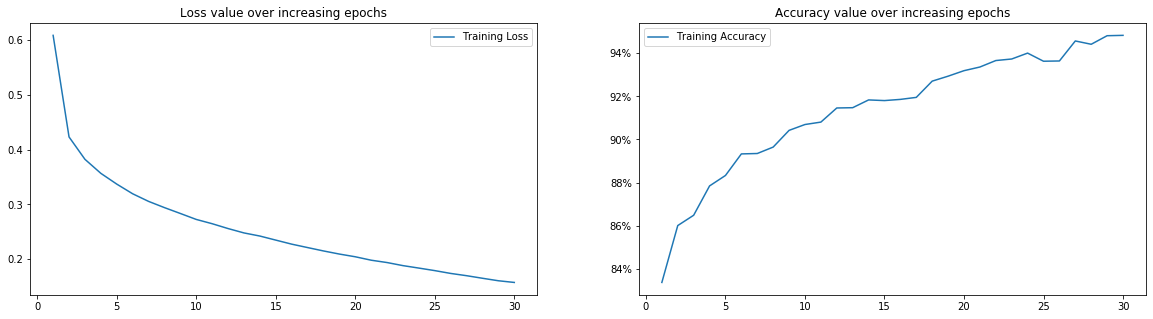

In [48]:
epochs = np.arange(epochs_train)+1
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs, train_losses, label='Training Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \
for x in plt.gca().get_yticks()])
plt.legend()
plt.show()

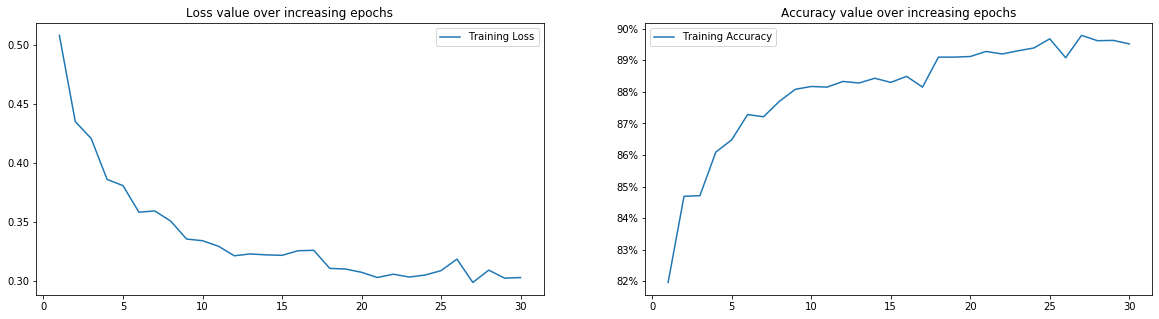

In [49]:
epochs = np.arange(epochs_train)+1
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.title('Loss value over increasing epochs')
plt.plot(epochs, val_losses, label='Training Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy value over increasing epochs')
plt.plot(epochs, val_accuracies, label='Training Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \
for x in plt.gca().get_yticks()])
plt.legend()
plt.show()

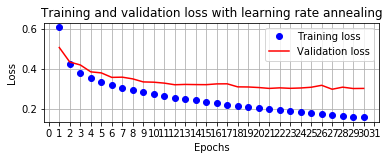

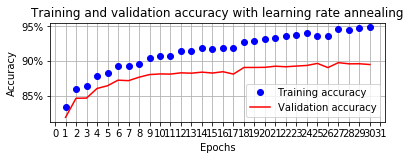

In [50]:
epochs = np.arange(epochs_train)+1
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
%matplotlib inline
plt.subplot(211)
plt.plot(epochs, train_losses, 'bo', label='Training loss')
plt.plot(epochs, val_losses, 'r', label='Validation loss')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation loss with learning rate annealing')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid('off')
plt.show()
plt.subplot(212)
plt.plot(epochs, train_accuracies, 'bo', \
label='Training accuracy')
plt.plot(epochs, val_accuracies, 'r', \
label='Validation accuracy')
plt.gca().xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.title('Training and validation accuracy with learning rate annealing')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) \
for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()

### Building a deeper neural network

In [51]:
def get_model():
    model = nn.Sequential(
        nn.Linear(28*28, 1000),
        nn.ReLU(),
        nn.Linear(1000, 1000),
        nn.ReLU(),
        nn.Linear(1000, 10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, opt

In [52]:
def get_model_no_hidden():
    model = nn.Sequential(
        nn.Linear(28*28, 10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, opt

In [53]:
# check pytorch version
print(torch.__version__)

1.11.0+cu113


Here, take note of the following:
* The model was unable to learn as well as when there were no hidden layers.
* The model overfit by a larger amount when there were two hidden layers compared to one hidden layer (the validation loss is higher in the model with two layers compared to the model with one layer).

* the model was unable to be trained
well when the input data wasn't scaled (brought down to a small range). Non-scaled
data (data with a higher range) can also occur in hidden layers (especially when we
have deep neural networks with multiple hidden layers) because of the matrix
multiplication that's involved in getting the values of nodes in hidden layers.

### Understanding the impact of batch normalization

In [54]:
# check cuda version
print(torch.version.cuda)

# check torch version
# print(torch.version.cudnn)

11.3


* Very small input values without batch normalization

In [55]:
# To scale the input dataset so that it has a very low value, we'll change the scaling that
# typically we do in the FMNISTDataset class by reducing the range of input values
# from 0 to 0.0001

class FMNISTDataset(Dataset):
    def __init__(self, x, y):
        x = x.float() / (255*1000)
        x = x.reshape(-1, x.shape[0])
        self.x = x
        self.y = y
        # self.x = self.x.reshape(self.x.shape[0], -1)
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, ix):
        x, y = self.x[ix], self.y[ix]
        return x.to(device), y.to(device)


In [56]:
def get_model():
    class neuralnet(nn.Module):
        def __init__(self) -> None:
            super().__init__()
            self.input_to_hidden = nn.Linear(28*28, 1000)
            self.batch_norm = nn.BatchNorm1d(1000)
            self.hidden_layer_activation = nn.Relu()
            self.hiddent_to_output = nn.Linear(1000, 10)

        def forward(self, x):
            x = self.input_to_hidden(x)
            x0 = self.batch_norm(x)
            x1 = self.hidden_layer_activation(x0)
            x2 = self.hiddent_to_output(x1)
            return x2, x1
    
    model = neuralnet().to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    return model, loss_fn, optimizer

* Batch normalization helps considerably when training deep neural
networks. It helps us avoid gradients becoming so small that the
weights are barely updated.
* Note that in the preceding scenario, we attained high validation accuracy sooner than
when there was no batch normalization at all. This could have been the result of
normalizing the intermediate layers, resulting in fewer chances of saturation
occurring in the weights.

### The concept of overfitting

Having high accuracy on the training dataset and considerably
lower accuracy on the validation dataset refers to the scenario of
overfitting.<br>
Some of the typical strategies that are employed to reduce the effect of overfitting are as follows:
1. Dropout
2. Regularization

* Impact of adding dropout <br>
Dropout is a mechanism that used so that the weight value aren't updated as frequently. This helps in reducing overfitting.

We have already learned that whenever loss.backward() is calculated, a weight
update happens. Typically, we would have hundreds of thousands of parameters
within a network and thousands of data points to train our model on. This gives us
the possibility that while the majority of parameters help in training the model
reasonably, certain parameters can be fine-tuned for the training images, resulting in
their values being dictated by only a few images in the training dataset. This, in turn,
results in the training data having a high accuracy but not that the validation dataset
generalizes.

Dropout is a mechanism that randomly chooses a specified percentage of activations
and drops them to 0. In the next iteration, another random set of hidden units are
switched off. This way, the neural network does not optimize for edge cases as the
network does not get that many opportunities to adjust the weight to memorize for
edge cases (given that the weight is not updated in each iteration).

Note that, during prediction, dropout doesn't need to be applied since this
mechanism can only be applied to a trained model. Furthermore, the weights will be
downscaled automatically during prediction (evaluation) to adjust for the magnitude
of the weights (since all the weights are present during prediction time).

Lưu ý: 
* model.train() sẽ áp dụng dropout và batchnormalization nếu có
* model.val() sẽ loại bỏ dropout và batchnormalization

In [57]:
def get_model():
    model = nn.Sequential(
        nn.Dropout(0.25),
        nn.Linear(28*28, 1000),
        nn.ReLU(),
        nn.Dropout(0.25),
        nn.Linear(1000, 10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

* Impact of regularization <br>
Regularization is a mechanism that used so that the weight value aren't updated as frequently. This helps in reducing overfitting.
Regularization is a technique in which we penalize the model for having high weight
values. Hence, it is a dual objective function – minimize the loss of training data, as
well as the weight values. In this section, we will learn about two types of
regularization: <br>
L1 regularization <br>
L2 regularization

* L1 regularization

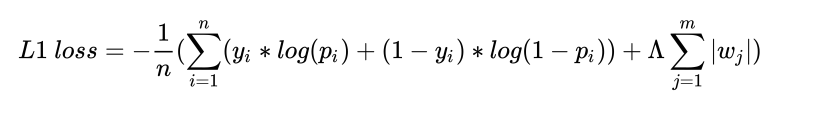

In [58]:
# insert iamge to markdown
from IPython.display import Image
Image(filename='l1_regularization.png')

In [59]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    l1_regularization = 0
    for param in model.parameters():
        l1_regularization += torch.norm(param, 1)
    batch_loss = loss_fn(prediction, y) + 0.0001 * l1_regularization
    # calculate the gradients
    batch_loss.backward()
    # update the weights
    opt.step()
    # reset the gradients
    opt.zero_grad()
    
    return batch_loss.item()

* L2 regularization

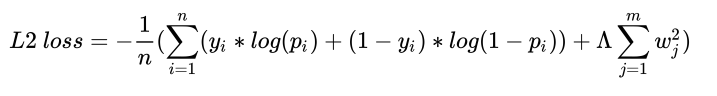

In [60]:
# insert iamge to markdown
from IPython.display import Image
Image(filename='l2_regularization.png')

In [61]:
def train_batch(x, y, model, opt, loss_fn):
    model.train()
    prediction = model(x)
    l1_regularization = 0
    for param in model.parameters():
        l2_regularization += torch.norm(param, 2)
    batch_loss = loss_fn(prediction, y) + 0.01 * l2_regularization
    # calculate the gradients
    batch_loss.backward()
    # update the weights
    opt.step()
    # reset the gradients
    opt.zero_grad()
    
    return batch_loss.item()

### Summary
We started this chapter by learning about how an image is represented. Next, we
learned about how scaling, the value of the learning rate, our choice of optimizer, and
the batch size help improve the accuracy and speed of training. We then learned
about how batch normalization helps in increasing the speed of training and
addresses the issues of very small or large values in hidden layer. Next, we learned
about scheduling the learning rate to increase accuracy further. We then proceeded to
understand the concept of overfitting and learned about how dropout and L1 and L2
regularization help us avoid overfitting.
Now that we have learned about image classification using a deep neural network, as
well as the various hyperparameters that help train a model, in the next chapter, we
will learn about how what we've learned in this chapter can fail and how to address
this using convolutional neural networks.

In [62]:
import torch_geometric
from torch_geometric.datasets import TUDataset